In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
import json
from helpers import style
from helpers.afa import adaptive_filter
from tqdm import tqdm
from collections import Counter
import networkx as nx

from helpers.linkage import mutual_information_smooth
from helpers.pathtools import *
from helpers.metrics import *
from helpers.visuals import add_cabinet_periods

lda_path = '/home/rb/Documents/Data/models/lda/postwar-v3/'

style.load_style()

from helpers.dataloader import load

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'bayanpy', 'wurlitzer', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [16]:
dists, dat, _, keys = load(zscore_filter=False,time_agg='6M')

In [17]:
networks = {}
size_dicts = {}

for cd,(date, _) in enumerate(dists.groupby(dists.index)):
    rij, ri, m = mutual_information_smooth(theta = _.to_numpy())
    rij = pd.DataFrame(rij, index=[keys[int(i)] for i in _.columns], columns=[keys[int(i)] for i in _.columns])
    rij = rij.stack().reset_index().rename(columns={"level_0":"s","level_1":"t",0:"pmi"})
    rij = rij[(rij.s != rij.t) & (rij.pmi > 0)]

    sizes = _.mean()
    sizes.index = sizes.index.astype(int).map(keys)
    sizes = sizes.to_dict()
    g = nx.from_pandas_edgelist(df = rij, source='s', target='t', edge_attr=['pmi'])
    networks[date] = g
    size_dicts[cd] = list(sizes.items())

In [18]:
tc, g, sizes, paths, metadata = get_tc(networks, size_dicts, overlap_threshold=.65, louvain_res=3,verbose=False)

In [19]:
def plot_flows(g=None, 
               tc=None, 
               paths=[], 
               sizes={}, 
               annotate_max_topic=True, 
               add_non_path_nodes=True, 
               path_colors={},
               ax=None,
               save='figs/chains.pdf'):
    
    cids = [f"{i}_{c}" for i, cc in tc.clusterings.items() for c in range(len(cc.communities))]
    if add_non_path_nodes:
        for cid in cids:
            if cid not in g.nodes:
                g.add_node(cid)
                
    paths = sorted(paths, key=lambda x: int(x[0].split('_')[0]))
    layer_mapping = {node: int(node.split('_')[0]) for node in g.nodes}
    nx.set_node_attributes(g, layer_mapping, 'layer')
    pos = nx.multipartite_layout(g, subset_key='layer')
    
    node_chain_count = {node: 0 for node in g.nodes}
    node_colors = {node: "whitesmoke" for node in g.nodes}
    node_sizes = {node: 100 for node in g.nodes}

    for chain in paths:
        for node in chain:
            node_chain_count[node] += 1

    for idx, chain in enumerate(paths):
        color = path_colors[idx]
        for i in range(len(chain) - 1):
            if g.has_edge(chain[i], chain[i+1]):
                ax.plot([pos[chain[i]][0], pos[chain[i+1]][0]], [pos[chain[i]][1], pos[chain[i+1]][1]], color=color, zorder=0)

        for node in chain:
            node_colors[node] = color
            node_sizes[node] = 750

    for node in g.nodes:
        ax.scatter(*pos[node], s=node_sizes[node], c=node_colors[node], edgecolors='white', zorder=3,marker='s')
        if node_sizes[node] > 100:
            ax.scatter(*pos[node], s=node_sizes[node] * .99, c="black", edgecolors=None, alpha=.05, zorder = 4, marker=MarkerStyle("s", fillstyle="left"))
            ax.scatter(*pos[node], s=node_sizes[node] * .99, c="black", edgecolors=None, alpha=.05, zorder = 4, marker=MarkerStyle("s", fillstyle="right"))
            ax.scatter(*pos[node], s=node_sizes[node] * .99, c="black", edgecolors=None, alpha=.05, zorder = 4, marker=MarkerStyle("s", fillstyle="bottom"))

        if add_non_path_nodes == False and node_chain_count[node] == 0:
            continue
        if node_chain_count[node] > 0:
            period, com = (int(x) for x in node.split('_'))
            txt = node + '\n' + sizes[period][com].replace(' ', '\n').upper() if annotate_max_topic else node
            # ax.annotate(txt, xy=pos[node], xytext=(0, 0), textcoords='offset points', fontsize=4, color='black', ha='center', va='center', zorder=5, fontweight='bold')

    ax.axis('off')
    
    # Remove axis
    ax.axis('off')

    # Ticks
    x_nodes, y_nodes = [pos[node][0] for node in g.nodes],[pos[node][1] for node in g.nodes]
    for ix,date in {c:k for c,k in enumerate(sorted(networks.keys())) if c % 5 == 0}.items():
        y = min(y_nodes) + (min(y_nodes) * .1)
        x = sorted(list(set(x_nodes)))[ix]
        ax.annotate(text=date.year,xy=(x,y),fontsize=75,ha='center',va='center')

    plt.savefig(save,bbox_inches='tight',dpi=400)
    plt.show()

## Chain Stats

In [20]:
path_topics = {i:pd.DataFrame([item for items in p for item in tc.get_community(items)],columns=['topic']).value_counts() for i,p in enumerate(paths)}
pdf = pd.DataFrame({i:p.max() for i,p in path_topics.items()}.items(),columns=['path_id','max']).sort_values('max',ascending=False)
pdf['topics'] = pdf.path_id.apply(lambda i:', '.join(path_topics[i].reset_index().topic[:4]))
pdf['len'] = pdf.path_id.apply(lambda i: len(paths[i]))
pdf['max_topic_persistence'] = pdf['max'] / pdf['len']
pdf['mean_topic_persistence'] = pdf.path_id.apply(lambda i:np.mean(path_topics[i] / pdf['len'][i]))

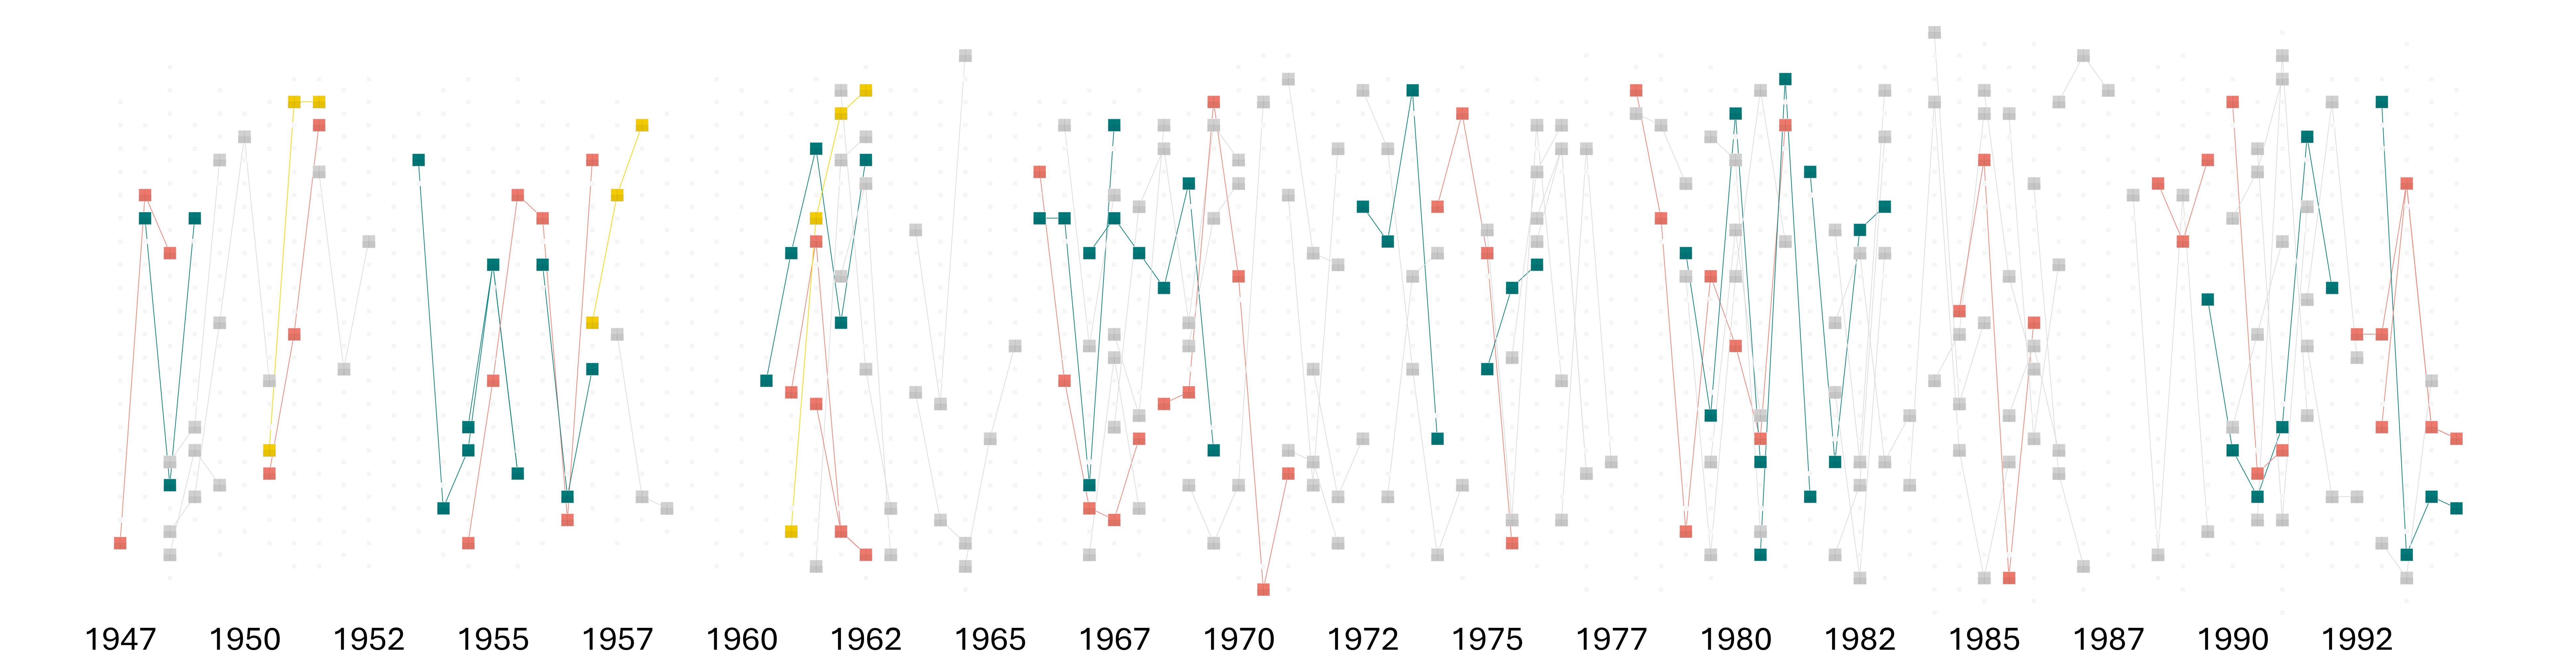

In [21]:
pc = {pid:'teal' if 'international' in tops else 'salmon' if 'education' in tops else 'gold' if 'agric' in tops else 'gainsboro' 
      for pid, tops in zip(pdf.path_id, pdf.topics)}

fig, ax = plt.subplots(figsize=(100,25))

plot_flows(g = g, 
           tc = tc,
           paths = paths,
           sizes = sizes, 
           path_colors=pc,
           annotate_max_topic=False,
           ax=ax,
           save)

In [26]:
pts = sorted(paths,key=len)
pts.reverse()

In [30]:
pt = pts[0]

r = []

for c,i in enumerate(pt):
    cls_ = tc.get_community(i)

    # for v in keys.values():
    for v in cls_:
        r.append({"p":c,"topic":v,"s":1})
r = pd.DataFrame(r)
r = r.drop_duplicates().pivot(index='topic',columns='p',values='s')
res = r.loc[r.sum(axis=1).sort_values().index].fillna(0)

In [31]:
fo = res.gt(0).idxmax(axis=1).to_dict()

(-0.65, 13.65, -1.1, 23.1)

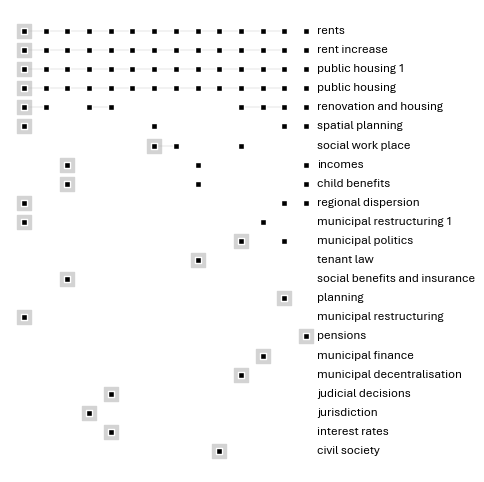

In [36]:
f,ax = plt.subplots(figsize=(4,6))

for z,(i,r) in enumerate(res.iterrows()):
    X = r.index.tolist()
    Y = r.tolist()
    
    for c_,(xv,yv) in enumerate(zip(X,Y)):

        if yv > 0:
            ax.scatter(x = [xv],
                    y = [z],
                    s = 25 if yv > 0.0 else 0,
                    color = 'black',
                    zorder=0,
                    linewidths=1,
                    edgecolor='white',
                    clip_on=False,
                    marker='s'
                    )
        
        if c_ < len(X) - 2 and yv > 0.0:

            if Y[c_+1] > 0.0:
                next_val = X[c_+1]
                ax.plot([xv,next_val],[z,z],color='darkgray',linewidth=.2,zorder=-1)
        
        if fo[i] == xv:
            ax.scatter(x=[xv],y=[z],s=100,color='lightgray',zorder=-2,clip_on=False,marker='s')

    ax.annotate(i,xy=(X[-1] + .5,z),ha='left',va='center',fontsize=9,clip_on=False)
plt.axis('off')